Question 1)

a)

In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.io import loadmat

Import and read in the iris dataset

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
convert_species = np.vectorize(lambda x : "setosa" if x==0 else ("versicolor" if x==1 else "virginica"))
iris_df["target"] = convert_species(iris.target)

In [3]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Import and read in the indian pines dataset

In [4]:
indian = loadmat(os.path.join(os.getcwd(), "indianR.mat"))
data = np.array(indian["X"]).T
targets = np.array(indian["gth"])[0]
indian_df = pd.DataFrame(data=data)
indian_df["target"] = targets

In [5]:
indian_df.head()

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,target
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1090,1112,1090,1062,1069,1057,1020,1020,1005,3
1,3344,4388,4334,4279,4543,4999,5026,4932,4953,4699,...,1096,1110,1086,1071,1077,1047,1030,1006,1015,3
2,3512,4146,4416,4132,4661,4898,5111,4927,4851,4733,...,1097,1093,1080,1061,1068,1055,1029,1025,1010,3
3,3000,4011,4330,4195,4610,4850,4992,4921,4899,4627,...,1101,1103,1077,1066,1064,1051,1030,1015,1000,3
4,3518,4392,4511,4427,4790,5088,5265,5094,5155,4891,...,1104,1104,1095,1063,1077,1055,1029,1029,1025,3


Both indian and iris datasets have successfully been loaded. Now, we need to setup PCA and LDA

First is PCA. PCA needs to scale the data first and then deconstruct the data into its principal components

In [6]:
def scale(df):
    inputs = df.iloc[:, :-1].to_numpy()
    scale = MinMaxScaler()
    scale.fit(inputs.astype(float))
    inputs = scale.transform(inputs)
    
    scaled_df = pd.DataFrame(data=inputs)

    scaled_df["target"] = df["target"]
    
    return scaled_df

In [7]:
def fit_pca(df, **kwargs):
    n_components = kwargs.get("n_components", len(df.columns)-1)
    plot_variance = kwargs.get("plot_variance", True)
    
    inputs = df.iloc[:, :-1].to_numpy()
    
    pca = PCA(n_components=n_components)
    pc = pca.fit(inputs)
    
    return pc

In [8]:
def transform_pca(df, pc):
    inputs = df.iloc[:, :-1].to_numpy()
    transformed_df = pd.DataFrame(data=pc.transform(inputs))
    transformed_df["target"] = df["target"]
    return transformed_df

In [69]:
def plot_variance(pc, n_components=None):
    pc_cols = lambda x : [*map(lambda y : f"PC-{y}", list(range(x)))]
        
    n_comps = n_components if n_components is not None else pc.n_components
        
    plt.figure(figsize=(18,12))
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 18})
    plt.bar(pc_cols(n_comps), pc.explained_variance_ratio_[:n_comps])
    plt.title("Explained Variance Ratio vs. Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.xlabel("Principal Component")
    plt.ylim([0, 1])
    
    return

In [83]:
def plot_pca_lda(df, **kwargs):
    title = kwargs.get("title", "Plot of Data With First Two Components")
    xlabel = kwargs.get("xlabel", "First Component")
    ylabel = kwargs.get("ylabel", "Second Component")
    eigens = kwargs.get("eigens", None)
    alpha = kwargs.get("alpha", 0.75)
    
    labels = np.unique(df["target"])
    
    fig = plt.figure(figsize=(18,12))
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 18})
    #fig, ax = plt.subplots(1,1, figsize=(18,12), style="ggplot")
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    for label in labels:
        first_two = df.loc[df["target"] == label].iloc[:, 0:2].to_numpy()
        ax.scatter(first_two[:, 0], first_two[:, 1], label=label, alpha=alpha)
        
    if eigens is not None:
        eig_vec = eigens[0][:2]
        eig_val = eigens[1][:2]
        for vec, val in zip(eig_vec, eig_val.T):
            ax.plot([0, np.sqrt(vec)*val[0]], [0, np.sqrt(vec)*val[1]], "k-", lw=2)
        
    ax.legend()
    
    return

In [80]:
def get_eigens(df):
    inputs = df.iloc[:, :-1].to_numpy()
    cov = np.cov(inputs.T)
    eig_vec, eig_val = np.linalg.eig(cov)
    
    print(f"Eigen Values:\n{eig_val}")
    print(f"Eigen Vectors:\n{eig_vec}")
    
    return eig_vec, eig_val

Now to create the same functionality for LDA.

In [57]:
def perform_lda(df, **kwargs):
    n_components = kwargs.get("n_components", len(np.unique(df["target"].values))-1)
    
    inputs = df.iloc[:, :-1].to_numpy()
    targets = np.array(df["target"].values)
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    transform_df = pd.DataFrame(data=lda.fit(inputs, targets).transform(inputs))
    transform_df["target"] = df["target"]
    
    return transform_df

Eigen Values:
[[ 1.00000000e+00  2.27117367e-16  1.58067971e-16  8.17929707e-17]
 [ 0.00000000e+00  1.00000000e+00 -3.34545298e-16 -3.45648222e-17]
 [ 0.00000000e+00  3.46217222e-16  1.00000000e+00  8.87035040e-17]
 [ 0.00000000e+00  4.27653296e-17 -1.11519743e-16  1.00000000e+00]]
Eigen Vectors:
[0.23245325 0.0324682  0.00959685 0.00176432]


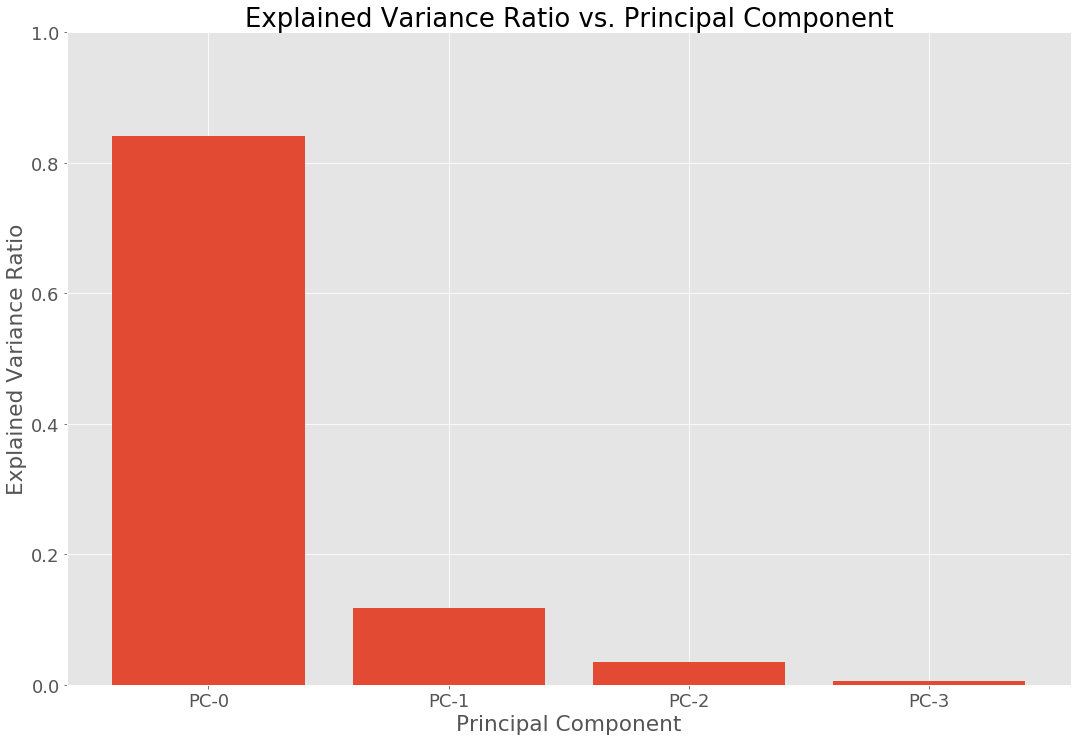

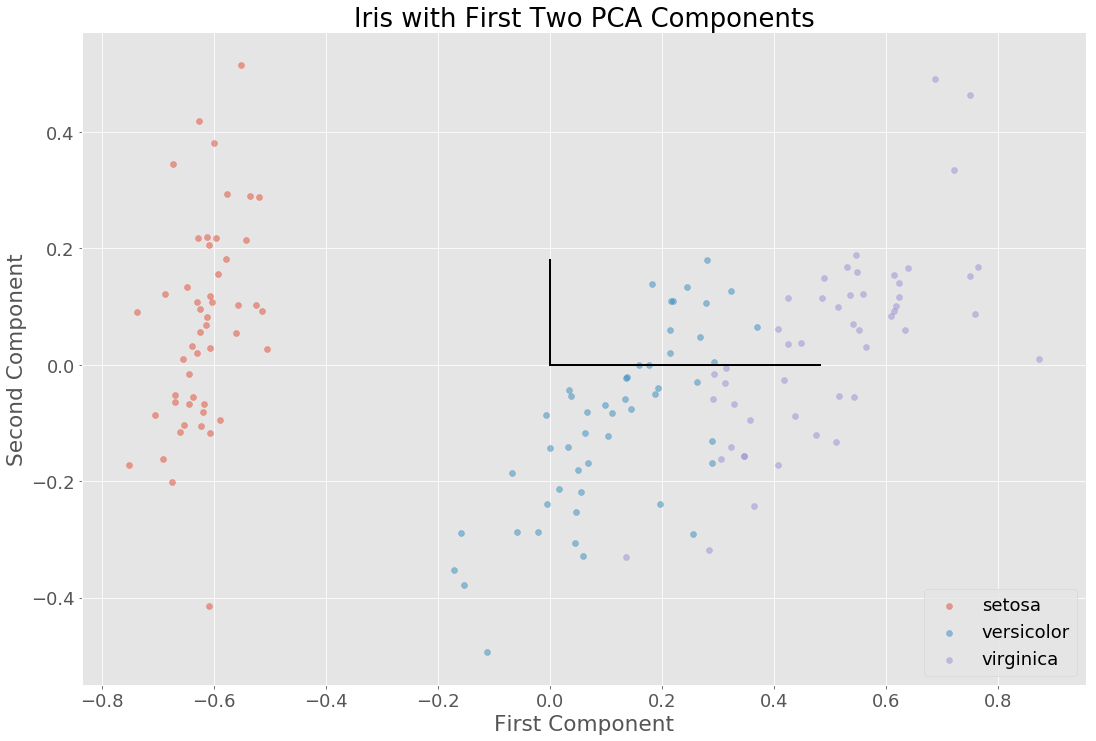

In [84]:
iris_scaled = scale(iris_df)
pc = fit_pca(iris_scaled)
plot_variance(pc)
iris_pc = transform_pca(iris_scaled, pc)
eigens = get_eigens(iris_pc)
plot_pca_lda(iris_pc, eigens=eigens, title="Iris with First Two PCA Components")

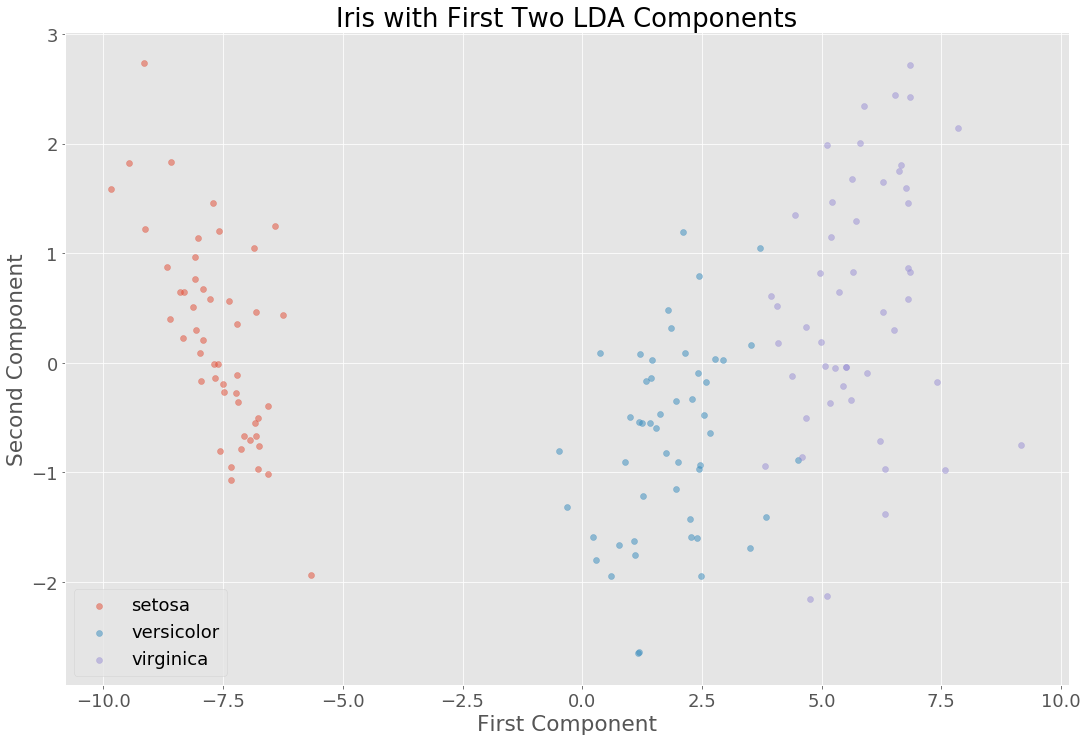

In [85]:
iris_lda = perform_lda(iris_df)
plot_pca_lda(iris_lda, title="Iris with First Two LDA Components")

Eigen Values:
[[-1.00000000e+00  4.59916563e-15 -3.75633322e-18 ... -2.15025060e-17
  -5.60341787e-18 -3.37432928e-18]
 [-4.51519183e-15 -1.00000000e+00 -5.60143577e-15 ... -3.28071866e-17
   1.01595415e-17  4.08579976e-17]
 [-3.75462611e-18 -5.61933976e-15  1.00000000e+00 ... -7.96803053e-17
  -7.20883278e-17 -3.59728622e-17]
 ...
 [-1.68744346e-16 -1.97854625e-17  1.25317217e-16 ... -1.92561392e-15
   2.51822878e-15  2.15128605e-15]
 [-5.99042616e-18  4.87288225e-18  4.73089564e-17 ...  2.63678077e-15
  -1.30645641e-15 -5.99926435e-16]
 [-2.93866007e-17 -4.02869443e-18 -6.38077530e-17 ...  5.74433857e-15
   1.05332663e-15 -2.96708525e-15]]
Eigen Vectors:
[3.67731128e+00 4.96901663e-01 7.84033505e-02 2.73551799e-02
 1.42260574e-02 1.24880767e-02 1.18110029e-02 1.08382753e-02
 8.50959621e-03 6.68411181e-03 5.98779736e-03 5.52667864e-03
 5.07948708e-03 4.41609756e-03 4.04048229e-03 3.71317997e-03
 3.40169660e-03 2.75400745e-03 2.18710558e-03 2.01716119e-03
 1.39315969e-03 1.31367696e-03

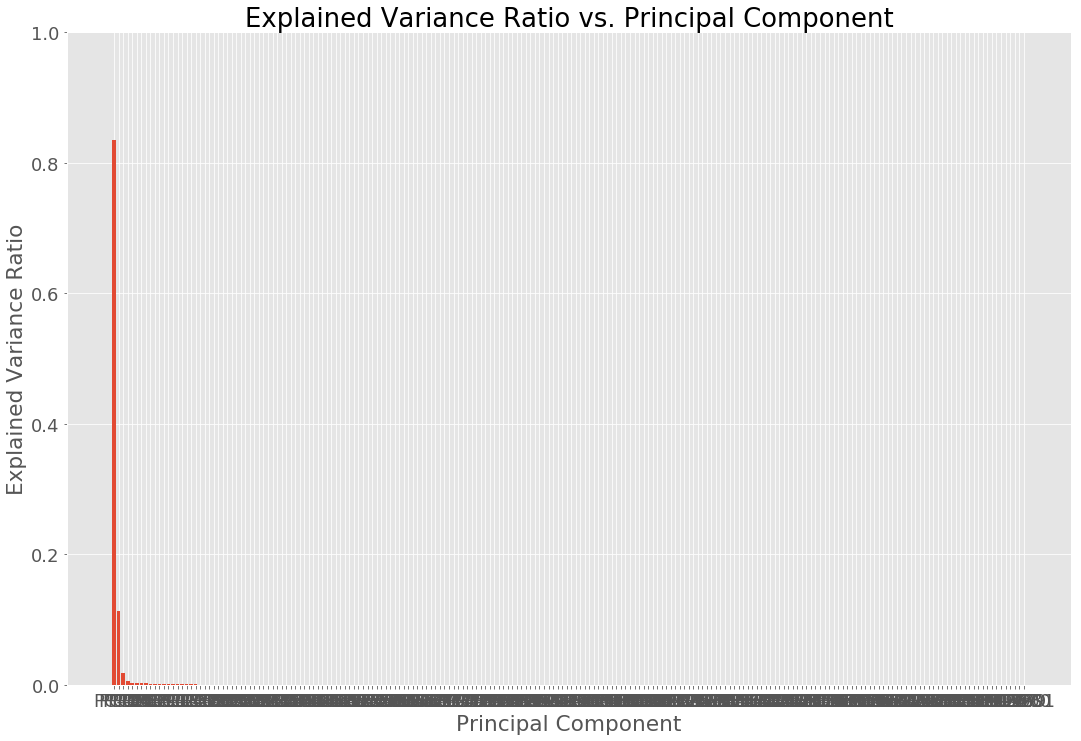

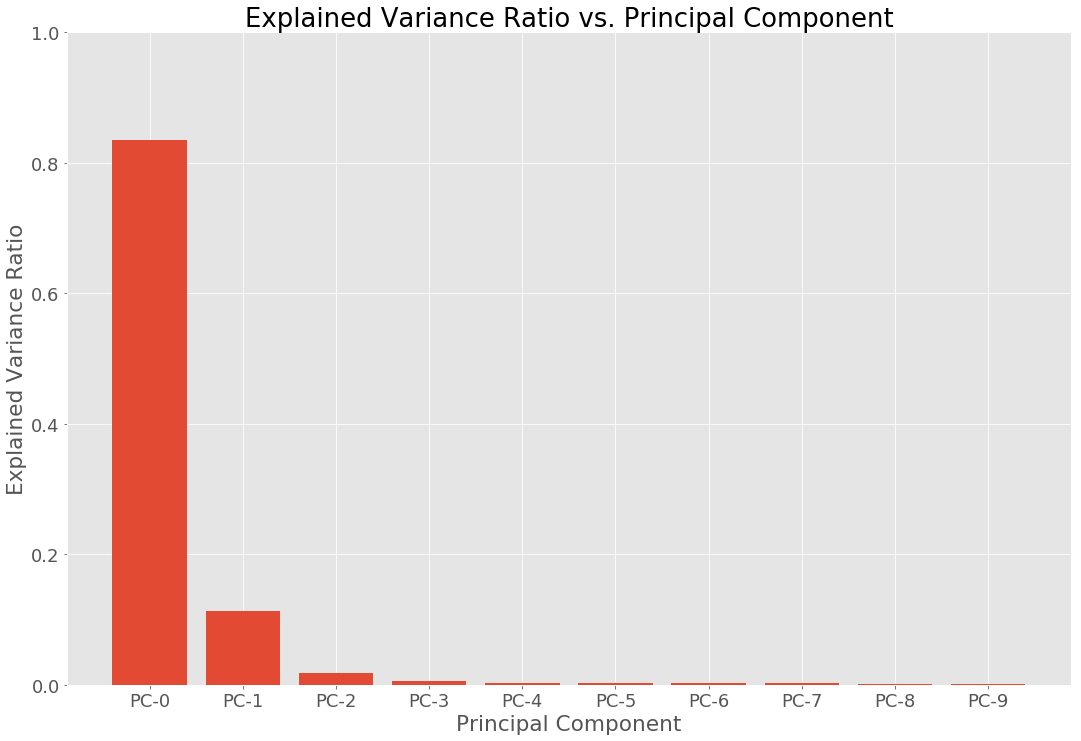

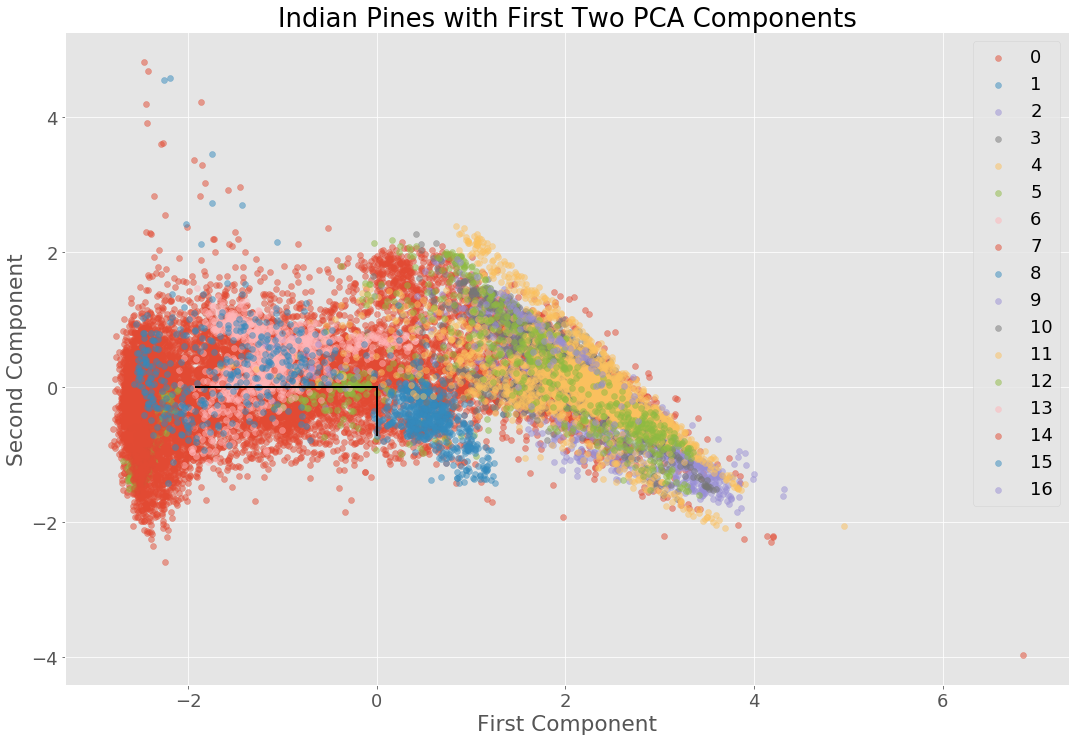

In [86]:
indian_scaled = scale(indian_df)
pc = fit_pca(indian_scaled)
plot_variance(pc)
plot_variance(pc, n_components=10)
indian_pc = transform_pca(indian_scaled, pc)
eigens = get_eigens(indian_pc)
plot_pca_lda(indian_pc, eigens=eigens, title="Indian Pines with First Two PCA Components")

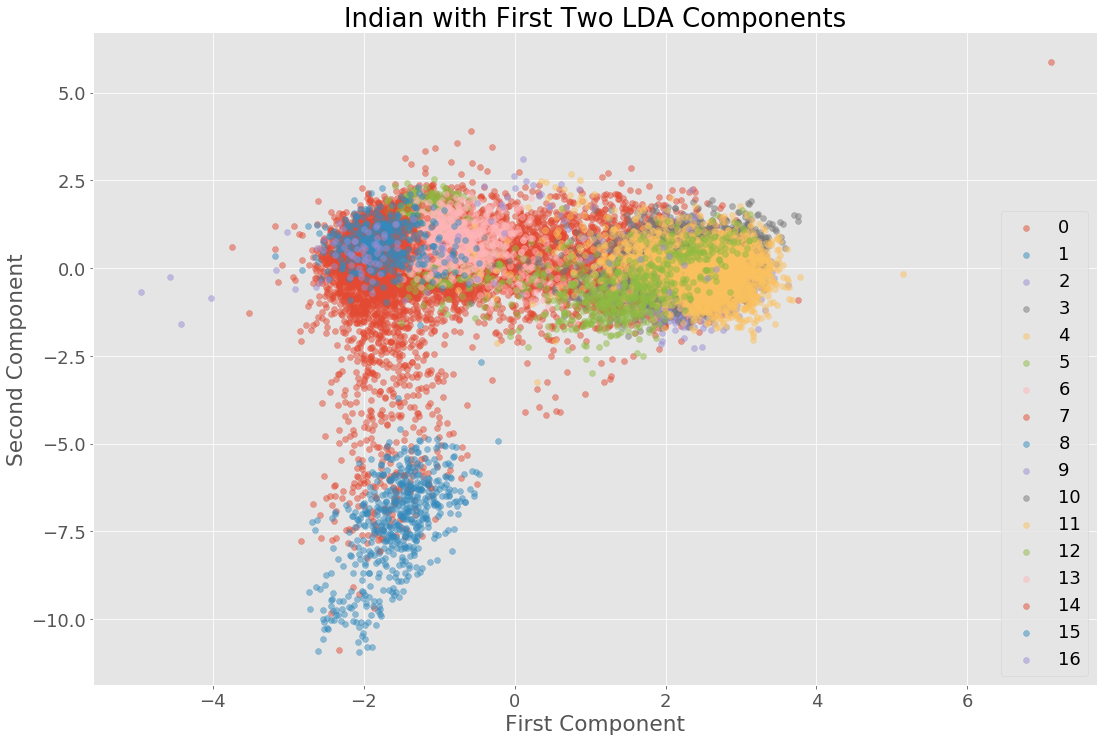

In [87]:
indian_lda = perform_lda(indian_df)
plot_pca_lda(indian_lda, title="Indian with First Two LDA Components")